# Energy Efficiency

#### Notebook Contents


- Data input and summary
- Exploratory analysis
- Creating Energy Efficiency Class
- Data prep for models
- Heating and Cooling node separate regression models (base models + Neural networks)
- Energy Efficiency 2-class, classification models (base models + Neural networks)

In [1]:
#Loading required libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn') #set same style for all plots
pd.options.mode.chained_assignment = None  # suppress chained assignment warning

#### Data import and summaries

In [2]:
energy_df = pd.read_csv('ENB2012_data.csv')
print('Shape of input')
print(energy_df.shape)
print('First 5 rows')
print(energy_df.head())
print('Missing values')
print(energy_df.isnull().sum())

Shape of input
(768, 10)
First 5 rows
     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
Missing values
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64


All the datapoints are numeric. There is no no need of any missing value imputation.

In [3]:
#Assigning column names
energy_df.columns = ['relative_compactness','surface_area','wall_area','roof_area','overall_height','orientation','glazing_area','glazing_area_distribution','heating_load','cooling_load']
energy_df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


### EDA

In [56]:
#Summary statistics on the database
energy_df.describe()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [53]:
#Assessing the correlation between feature and response variables:
correlation_mat = energy_df.corr()
print("Correlation Between X and Y")
print(correlation_mat.iloc[:,8:10])

Correlation Between X and Y
                           heating_load  cooling_load
relative_compactness           0.622272      0.634339
surface_area                  -0.658120     -0.672999
wall_area                      0.455671      0.427117
roof_area                     -0.861828     -0.862547
overall_height                 0.889431      0.895785
orientation                   -0.002587      0.014290
glazing_area                   0.269841      0.207505
glazing_area_distribution      0.087368      0.050525
heating_load                   1.000000      0.975862
cooling_load                   0.975862      1.000000


From the Correlation table above we can conclude that Heating Load and Cooling Load are highly correlated and their correlation with the other features are almost identical, therefore we will proceed the EDA with only one of the response variables. 

We also notice that 'Orientation', and both 'Glazing Area' variables have almost no correlation with the response variables, therefore we will exclude them from the EDA since the scatterplot will be inconclusive.

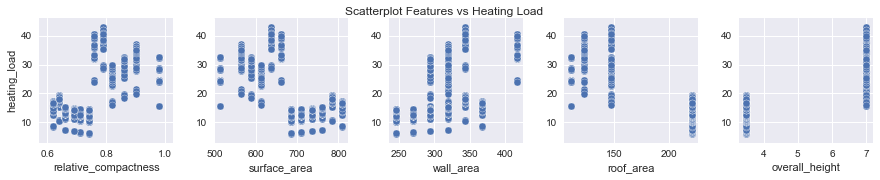

In [55]:
fig = plt.figure(figsize = (5,5))
ax = sns.pairplot(x_vars=['relative_compactness', 'surface_area', 'wall_area', 'roof_area',
       'overall_height'],y_vars=['heating_load'] ,data=energy_df)
ax.fig.suptitle('Scatterplot Features vs Heating Load')
plt.show()

Lower compactness is mostly associated with lower energy loads, as we can clearly see two clusters. We can also infer the same for surface area, but with oposite signs (higher surface = lower loads).

The graph above also indicates that the higher the wall area, the higher the energy loads. This relationship is not straightfoward, but we can see a slight positive trend.

Higher roof area are more associated with lower energy loads as seen in the graph. However, the data given only shows 4 different roof areas, making it difficult to infer the relationship.

From the pairplot above we can see that Overall Height has only two values, but the data shows that higher heights are associated with higher loads as well.

#### Combining heating and cooling load

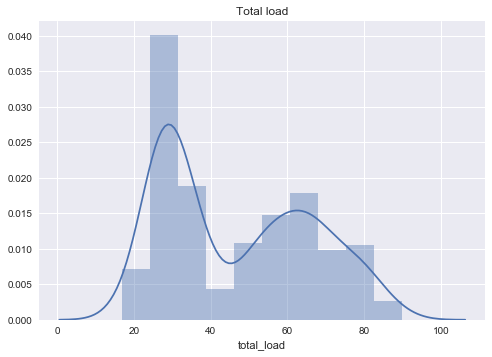

In [4]:
energy_df['total_load'] = energy_df['heating_load'] + energy_df['cooling_load']
sns.distplot(energy_df['total_load'])
plt.title('Total load');

### Creating efficiency class based on above distribution

In [5]:
energy_df['efficiency_class'] = 1
energy_df.loc[energy_df.total_load < 45, ['efficiency_class']] = 0
energy_df.loc[energy_df.total_load > 70 , ['efficiency_class']] = 2
energy_df.groupby('efficiency_class')['efficiency_class'].count()

efficiency_class
0    394
1    259
2    115
Name: efficiency_class, dtype: int64

### Data prep for modelling

In [6]:
X = energy_df.iloc[:,0:8]
y_cool = energy_df['heating_load'].values.ravel()
y_heat = energy_df['cooling_load'].values.ravel()
y_eff_class = energy_df['efficiency_class'].values.ravel()
X.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

#Heating load
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(X, y_heat, test_size = 0.2, random_state = 10)

X_train_heat = scaler.fit_transform(X_train_heat)
X_test_heat = scaler.transform(X_test_heat)

#Cooling load
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(X, y_cool, test_size = 0.2, random_state = 10)

X_train_cool = scaler.fit_transform(X_train_cool)
X_test_cool = scaler.transform(X_test_cool)

#Efficiency classifier
X_train_eff_class, X_test_eff_class, y_train_eff_class, y_test_eff_class = train_test_split(X, y_eff_class, test_size = 0.2, random_state = 10)

X_train_eff_class = scaler.fit_transform(X_train_eff_class)
X_test_eff_class = scaler.transform(X_test_eff_class)

### Predicting heating and cooling load

#### Sklearn Regressors

In [8]:
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [9]:
model_results_regression = pd.DataFrame(index=None, columns=['model','heating_train_r2', 'heating_test_r2', 'cooling_train_r2', 'cooling_test_r2'])

In [10]:
#Ridge regression

model_name = 'Ridge'
param_grid = {'alpha':[0.01, 0.1, 0.5, 1, 10, 50, 100]}

model = Ridge()

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_cool, y_train_cool)

print('Best parameters for cooling load {}'.format(grid_search.best_params_))
#
train_r2_cool = grid_search.score(X_train_cool, y_train_cool)
test_r2_cool = grid_search.score(X_test_cool, y_test_cool)

#
grid_search.fit(X_train_heat, y_train_heat)
print('Best parameters for heating load {}'.format(grid_search.best_params_))

train_r2_heat = grid_search.score(X_train_heat, y_train_heat)
test_r2_heat = grid_search.score(X_test_heat, y_test_heat)

#Saving results
model_results_regression = model_results_regression.append(pd.Series({'model':model_name,'heating_train_r2':train_r2_heat, 'heating_test_r2':test_r2_heat, 'cooling_train_r2':train_r2_cool,'cooling_test_r2':test_r2_cool}),ignore_index=True)
model_results_regression

Best parameters for cooling load {'alpha': 0.01}
Best parameters for heating load {'alpha': 0.01}


,model,heating_train_r2,heating_test_r2,cooling_train_r2,cooling_test_r2
0,Ridge,0.882469,0.90788,0.912346,0.931279


In [11]:
#Linear SVM

model_name = 'LinearSVM'
param_grid = {'C':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100]}

model = LinearSVR()

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_cool, y_train_cool)

print('Best parameters for cooling load {}'.format(grid_search.best_params_))
#
train_r2_cool = grid_search.score(X_train_cool, y_train_cool)
test_r2_cool = grid_search.score(X_test_cool, y_test_cool)

#
grid_search.fit(X_train_heat, y_train_heat)
print('Best parameters for heating load {}'.format(grid_search.best_params_))

train_r2_heat = grid_search.score(X_train_heat, y_train_heat)
test_r2_heat = grid_search.score(X_test_heat, y_test_heat)

#Saving results
model_results_regression = model_results_regression.append(pd.Series({'model':model_name,'heating_train_r2':train_r2_heat, 'heating_test_r2':test_r2_heat, 'cooling_train_r2':train_r2_cool,'cooling_test_r2':test_r2_cool}),ignore_index=True)
model_results_regression

Best parameters for cooling load {'C': 50}
Best parameters for heating load {'C': 10}


,model,heating_train_r2,heating_test_r2,cooling_train_r2,cooling_test_r2
0,Ridge,0.882469,0.907880,0.912346,0.931279
1,LinearSVM,0.877914,0.905392,0.909409,0.933796


In [12]:
#SVM with Radial Kernel

model_name = 'Radial_SVM'
param_grid = {'C':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000], 'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10],'epsilon' : [0.01, 0.1, 0.5, 1] }

model = SVR(kernel='rbf')

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_cool, y_train_cool)

print('Best parameters for cooling load {}'.format(grid_search.best_params_))
#
train_r2_cool = grid_search.score(X_train_cool, y_train_cool)
test_r2_cool = grid_search.score(X_test_cool, y_test_cool)

#
grid_search.fit(X_train_heat, y_train_heat)
print('Best parameters for heating load {}'.format(grid_search.best_params_))

train_r2_heat = grid_search.score(X_train_heat, y_train_heat)
test_r2_heat = grid_search.score(X_test_heat, y_test_heat)

#Saving results
model_results_regression = model_results_regression.append(pd.Series({'model':model_name,'heating_train_r2':train_r2_heat, 'heating_test_r2':test_r2_heat, 'cooling_train_r2':train_r2_cool,'cooling_test_r2':test_r2_cool}),ignore_index=True)
model_results_regression

Best parameters for cooling load {'C': 1000, 'epsilon': 0.01, 'gamma': 1}
Best parameters for heating load {'C': 1000, 'epsilon': 0.5, 'gamma': 1}


,model,heating_train_r2,heating_test_r2,cooling_train_r2,cooling_test_r2
0,Ridge,0.882469,0.907880,0.912346,0.931279
1,LinearSVM,0.877914,0.905392,0.909409,0.933796
2,Radial_SVM,0.987780,0.975485,0.998830,0.995712


In [13]:
#Random Forest

model_name = 'Random_Forest'
param_grid = {'max_features':['auto', 'log2'], 'max_depth':[5,10,15,20,50]}

model = RandomForestRegressor(n_estimators= 500, n_jobs = -1, random_state = 10)

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_cool, y_train_cool)

print('Best parameters for cooling load {}'.format(grid_search.best_params_))
#
train_r2_cool = grid_search.score(X_train_cool, y_train_cool)
test_r2_cool = grid_search.score(X_test_cool, y_test_cool)

#
grid_search.fit(X_train_heat, y_train_heat)
print('Best parameters for heating load {}'.format(grid_search.best_params_))

train_r2_heat = grid_search.score(X_train_heat, y_train_heat)
test_r2_heat = grid_search.score(X_test_heat, y_test_heat)

#Saving results
model_results_regression = model_results_regression.append(pd.Series({'model':model_name,'heating_train_r2':train_r2_heat, 'heating_test_r2':test_r2_heat, 'cooling_train_r2':train_r2_cool,'cooling_test_r2':test_r2_cool}),ignore_index=True)
model_results_regression

Best parameters for cooling load {'max_depth': 15, 'max_features': 'auto'}
Best parameters for heating load {'max_depth': 15, 'max_features': 'log2'}


,model,heating_train_r2,heating_test_r2,cooling_train_r2,cooling_test_r2
0,Ridge,0.882469,0.907880,0.912346,0.931279
1,LinearSVM,0.877914,0.905392,0.909409,0.933796
2,Radial_SVM,0.987780,0.975485,0.998830,0.995712
3,Random_Forest,0.996127,0.976357,0.999717,0.997355


In [14]:
#Gradient Boost

model_name = 'GradientBoost'
param_grid = {'max_features':['auto', 'log2'], 'max_depth':[5,10,15,20,50], 'learning_rate':[0.01,0.1,1]}

model =  GradientBoostingRegressor(random_state = 10, n_estimators = 500)

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_cool, y_train_cool)

print('Best parameters for cooling load {}'.format(grid_search.best_params_))
#
train_r2_cool = grid_search.score(X_train_cool, y_train_cool)
test_r2_cool = grid_search.score(X_test_cool, y_test_cool)

#
grid_search.fit(X_train_heat, y_train_heat)
print('Best parameters for heating load {}'.format(grid_search.best_params_))

train_r2_heat = grid_search.score(X_train_heat, y_train_heat)
test_r2_heat = grid_search.score(X_test_heat, y_test_heat)

#Saving results
model_results_regression = model_results_regression.append(pd.Series({'model':model_name,'heating_train_r2':train_r2_heat, 'heating_test_r2':test_r2_heat, 'cooling_train_r2':train_r2_cool,'cooling_test_r2':test_r2_cool}),ignore_index=True)
model_results_regression

Best parameters for cooling load {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'auto'}
Best parameters for heating load {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2'}


,model,heating_train_r2,heating_test_r2,cooling_train_r2,cooling_test_r2
0,Ridge,0.882469,0.907880,0.912346,0.931279
1,LinearSVM,0.877914,0.905392,0.909409,0.933796
2,Radial_SVM,0.987780,0.975485,0.998830,0.995712
3,Random_Forest,0.996127,0.976357,0.999717,0.997355
4,GradientBoost,0.999622,0.996159,0.999959,0.998555


In [15]:
X.shape

(768, 8)

#### Neural networks

In [16]:
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
np.random.seed(10)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- The two regression models are built seprately similar to other algorithms
- Another reason to split the model creation is to avoid retraining of the same model
- The models are written using scikit_learn wrapper in order to use scikit learn functions easily

In [54]:
from keras.wrappers.scikit_learn import KerasRegressor

def create_model_regressor_cooling():
    #create model
    model2 = Sequential()
    model2.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
    model2.add(Dense(4, kernel_initializer = 'normal', activation = 'relu')) # hidden layer
    model2.add(Dense(10, kernel_initializer = 'normal', activation = 'linear'))
    model2.add(Dense(1, kernel_initializer='normal'))
    #compile model
    model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    #return model
    return model2

In [20]:
from keras.wrappers.scikit_learn import KerasRegressor

def create_model_regressor_heating():
    #create model
    model = Sequential()
    model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'relu')) # hidden layer
    model.add(Dense(10, kernel_initializer = 'normal', activation = 'linear'))
    model.add(Dense(1, kernel_initializer='normal'))
    #compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

The final version of the model has following architecture

1. Input layer with 8 nodes (same as input columns) with relu activation function
2. Hidden layer 1 with 4 nodes and relu activation function
3. Hidden layer with 10 nodes and linear activation function
4. Output layer with single node and no activation function
5. Adam optimzer with  learning rate of 0.01 and loss function of mean_squared_error

In [55]:
#Model training

model_name = 'Neural_Networks'
param_grid = {'epochs':[50, 100, 200] , 'batch_size':[20, 50, 100]}

Both the models are trained with same parameter grid

- epochs = 50, 100 and 200
- batch size = 20, 50, 100

In [56]:
model1 = KerasRegressor(build_fn = create_model_regressor_cooling , verbose = 0)

grid_search = GridSearchCV(model1 , param_grid , cv =5)

grid_search.fit(X_train_cool, y_train_cool)
#
print('Best parameters for cooling load {}'.format(grid_search.best_params_))

train_r2_cool = r2_score(y_train_cool, grid_search.predict(X_train_cool))
test_r2_cool = r2_score(y_test_cool, grid_search.predict(X_test_cool))

Best parameters for cooling load {'batch_size': 20, 'epochs': 200}


In [23]:
model2 = KerasRegressor(build_fn = create_model_regressor_heating , verbose = 0)
grid_search = GridSearchCV(model2 , param_grid , cv =5)

grid_search.fit(X_train_heat, y_train_heat)
print('Best parameters for heating load {}'.format(grid_search.best_params_))

train_r2_heat = r2_score(y_train_heat, grid_search.predict(X_train_heat))
test_r2_heat = r2_score(y_test_heat, grid_search.predict(X_test_heat))

Best parameters for heating load {'batch_size': 20, 'epochs': 200}


In [66]:
#Saving results
model_results_regression = model_results_regression.append(pd.Series({'model':model_name,'heating_train_r2':train_r2_heat, 'heating_test_r2':test_r2_heat, 'cooling_train_r2':train_r2_cool,'cooling_test_r2':test_r2_cool}),ignore_index=True)
model_results_regression

,model,heating_train_r2,heating_test_r2,cooling_train_r2,cooling_test_r2
0,Ridge,0.882469,0.907880,0.912346,0.931279
1,LinearSVM,0.877914,0.905392,0.909409,0.933796
2,Radial_SVM,0.987780,0.975485,0.998830,0.995712
3,Random_Forest,0.996127,0.976357,0.999717,0.997355
4,GradientBoost,0.999622,0.996159,0.999959,0.998555
5,Neural_Networks,0.874705,0.899424,0.921846,0.936363


Text(0.5,1,'Train and Test r2 for Heating Load')

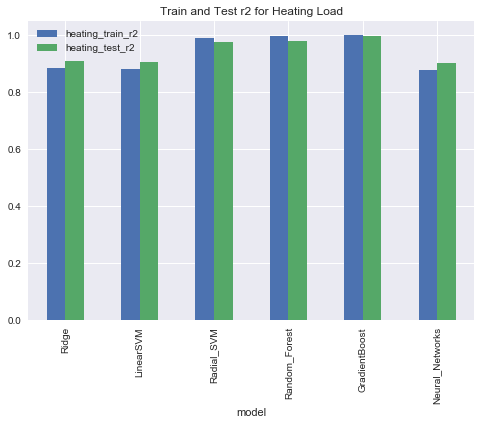

In [68]:
cols = ['model','heating_train_r2','heating_test_r2']
model_results_regression[cols].set_index('model').plot(kind = 'bar');
plt.title('Train and Test r2 for Heating Load')
#

### Predicting Heating Load
- The three models, SVM with radial kernel, Random Forest and Gradient Boosting models are performing best with high R-square
- The neural networks perform similar to Ridge and Linear SVM but it is performing worst among the tested models

Text(0.5,1,'Train and Test r2 for Cooling Load')

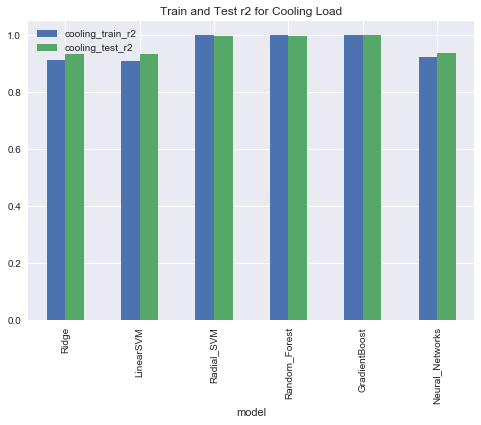

In [67]:
cols = ['model','cooling_train_r2','cooling_test_r2']
model_results_regression[cols].set_index('model').plot(kind = 'bar');
plt.title('Train and Test r2 for Cooling Load')
#

### Predicting Cooling Load
- The three models, SVM with radial kernel, Random Forest and Gradient Boosting models are performing best with high R-square
- The neural networks performed slightly better than Ridge and Linear SVM but ~8% worse than the best models in terms of R square

### Predicting Energy efficiency class

#### Sklearn Classifiers

In [27]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [28]:
model_results_classification = pd.DataFrame(index=None, columns=['model','train_acc', 'test_acc', 'train_f1', 'test_f1'])

In [29]:
#Logistic Regression

model_name = 'Logistic'
param_grid = {'C':[0.01, 0.1, 0.5, 1, 10, 50, 100]}

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_eff_class, y_train_eff_class)

print('Best parameters for efficiency classification {}'.format(grid_search.best_params_))

#Accuracy
train_acc = grid_search.score(X_train_eff_class, y_train_eff_class)
test_acc = grid_search.score(X_test_eff_class, y_test_eff_class)

#f1 score
train_f1 = f1_score(y_train_eff_class, grid_search.predict(X_train_eff_class), average= 'macro')
test_f1 = f1_score(y_test_eff_class, grid_search.predict(X_test_eff_class), average= 'macro')

#Saving results
model_results_classification = model_results_classification.append(pd.Series({'model':model_name,'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1,'test_f1':test_f1}),ignore_index=True)
model_results_classification

Best parameters for efficiency classification {'C': 0.5}


,model,train_acc,test_acc,train_f1,test_f1
0,Logistic,0.885993,0.902597,0.818092,0.809335


In [30]:
#Linear SVM

model_name = 'LinearSVM'
param_grid = {'C':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100]}

model = LinearSVC()

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_eff_class, y_train_eff_class)

print('Best parameters for efficiency classification {}'.format(grid_search.best_params_))

#Accuracy
train_acc = grid_search.score(X_train_eff_class, y_train_eff_class)
test_acc = grid_search.score(X_test_eff_class, y_test_eff_class)

#f1 score
train_f1 = f1_score(y_train_eff_class, grid_search.predict(X_train_eff_class), average= 'macro')
test_f1 = f1_score(y_test_eff_class, grid_search.predict(X_test_eff_class), average= 'macro')

#Saving results
model_results_classification = model_results_classification.append(pd.Series({'model':model_name,'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1,'test_f1':test_f1}),ignore_index=True)
model_results_classification

Best parameters for efficiency classification {'C': 0.5}


,model,train_acc,test_acc,train_f1,test_f1
0,Logistic,0.885993,0.902597,0.818092,0.809335
1,LinearSVM,0.885993,0.902597,0.818092,0.809335


In [31]:
#SVM with Radial Kernel

model_name = 'Radial_SVM'
param_grid = {'C':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000], 'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10]}

model = SVC(kernel='rbf')

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_eff_class, y_train_eff_class)

print('Best parameters for efficiency classification {}'.format(grid_search.best_params_))

#Accuracy
train_acc = grid_search.score(X_train_eff_class, y_train_eff_class)
test_acc = grid_search.score(X_test_eff_class, y_test_eff_class)

#f1 score
train_f1 = f1_score(y_train_eff_class, grid_search.predict(X_train_eff_class), average= 'macro')
test_f1 = f1_score(y_test_eff_class, grid_search.predict(X_test_eff_class), average= 'macro')

#Saving results
model_results_classification = model_results_classification.append(pd.Series({'model':model_name,'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1,'test_f1':test_f1}),ignore_index=True)
model_results_classification

Best parameters for efficiency classification {'C': 50, 'gamma': 0.5}


,model,train_acc,test_acc,train_f1,test_f1
0,Logistic,0.885993,0.902597,0.818092,0.809335
1,LinearSVM,0.885993,0.902597,0.818092,0.809335
2,Radial_SVM,0.988599,0.980519,0.988165,0.972685


In [32]:
#Random Forest

model_name = 'Random_Forest'
param_grid = {'max_features':['auto', 'log2'], 'max_depth':[5,10,15,20,50]}

model = RandomForestClassifier(n_estimators= 500, n_jobs = -1, random_state = 10)

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_eff_class, y_train_eff_class)

print('Best parameters for efficiency classification {}'.format(grid_search.best_params_))

#Accuracy
train_acc = grid_search.score(X_train_eff_class, y_train_eff_class)
test_acc = grid_search.score(X_test_eff_class, y_test_eff_class)

#f1 score
train_f1 = f1_score(y_train_eff_class, grid_search.predict(X_train_eff_class), average= 'macro')
test_f1 = f1_score(y_test_eff_class, grid_search.predict(X_test_eff_class), average= 'macro')

#Saving results
model_results_classification = model_results_classification.append(pd.Series({'model':model_name,'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1,'test_f1':test_f1}),ignore_index=True)
model_results_classification

Best parameters for efficiency classification {'max_depth': 10, 'max_features': 'auto'}


,model,train_acc,test_acc,train_f1,test_f1
0,Logistic,0.885993,0.902597,0.818092,0.809335
1,LinearSVM,0.885993,0.902597,0.818092,0.809335
2,Radial_SVM,0.988599,0.980519,0.988165,0.972685
3,Random_Forest,1.000000,0.980519,1.000000,0.965185


In [33]:
#Gradient Boost

model_name = 'GradientBoost'
param_grid = {'max_features':['auto', 'log2'], 'max_depth':[5,10,15,20,50], 'learning_rate':[0.01,0.1,1]}

model =  GradientBoostingClassifier(random_state = 10, n_estimators = 500)

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_eff_class, y_train_eff_class)

print('Best parameters for efficiency classification {}'.format(grid_search.best_params_))

#Accuracy
train_acc = grid_search.score(X_train_eff_class, y_train_eff_class)
test_acc = grid_search.score(X_test_eff_class, y_test_eff_class)

#f1 score
train_f1 = f1_score(y_train_eff_class, grid_search.predict(X_train_eff_class), average= 'macro')
test_f1 = f1_score(y_test_eff_class, grid_search.predict(X_test_eff_class), average= 'macro')

#Saving results
model_results_classification = model_results_classification.append(pd.Series({'model':model_name,'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1,'test_f1':test_f1}),ignore_index=True)
model_results_classification

Best parameters for efficiency classification {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'auto'}


,model,train_acc,test_acc,train_f1,test_f1
0,Logistic,0.885993,0.902597,0.818092,0.809335
1,LinearSVM,0.885993,0.902597,0.818092,0.809335
2,Radial_SVM,0.988599,0.980519,0.988165,0.972685
3,Random_Forest,1.000000,0.980519,1.000000,0.965185
4,GradientBoost,1.000000,0.987013,1.000000,0.983296


#### Neural networks

In [34]:
from keras.wrappers.scikit_learn import KerasClassifier

def create_model_classifier():
    #create model
    model = Sequential()
    model.add(Dense(8, input_dim=8, activation='relu'))
    model.add(Dense(4, activation='relu')) #hidden layer
    model.add(Dense(3,activation='sigmoid')) #output layer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


The final version of the model has following architecture

1. Input layer with 8 nodes (same as input columns) with relu activation function
2. Hidden layer 1 with 4 nodes and relu activation function
3. Output layer with 3 nodes(probability of each class) with sigmoid activation function
4. We have used categorical cross entropy as loss function with Adam optimzer (default learning rate of 0.01)

In [35]:
from keras.utils import np_utils

# convert integers to dummy variables (i.e. one hot encoded)
y_train_tns = np_utils.to_categorical(y_train_eff_class)
y_test_tns = np_utils.to_categorical(y_test_eff_class)

The model is trained for following grid to select the best paramters

- epochs = 50 and 200
- batch size = 10, 50 and 100

In [36]:
#Model training

model_name = 'Neural_Networks'
param_grid = {'epochs':[50, 200] , 'batch_size':[10, 50, 100]}

model = KerasClassifier(build_fn = create_model_classifier , verbose = 0)

grid_search = GridSearchCV(model , param_grid , cv =5)

grid_search.fit(X_train_eff_class, y_train_tns)

print('Best parameters for efficiency classification {}'.format(grid_search.best_params_))

#Accuracy
train_acc = accuracy_score(y_train_eff_class, grid_search.predict(X_train_eff_class))
test_acc = accuracy_score(y_train_eff_class, grid_search.predict(X_train_eff_class))

#f1 score
train_f1 = f1_score(y_train_eff_class, grid_search.predict(X_train_eff_class), average= 'macro')
test_f1 = f1_score(y_test_eff_class, grid_search.predict(X_test_eff_class), average= 'macro')

Best parameters for efficiency classification {'batch_size': 10, 'epochs': 200}


In [37]:
#Saving results
model_results_classification = model_results_classification.append(pd.Series({'model':model_name,'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1,'test_f1':test_f1}),ignore_index=True)
model_results_classification

,model,train_acc,test_acc,train_f1,test_f1
0,Logistic,0.885993,0.902597,0.818092,0.809335
1,LinearSVM,0.885993,0.902597,0.818092,0.809335
2,Radial_SVM,0.988599,0.980519,0.988165,0.972685
3,Random_Forest,1.000000,0.980519,1.000000,0.965185
4,GradientBoost,1.000000,0.987013,1.000000,0.983296
5,Neural_Networks,0.982085,0.982085,0.982888,0.972685


Text(0.5,1,'Train and Test accuracy for Efficiency classifier')

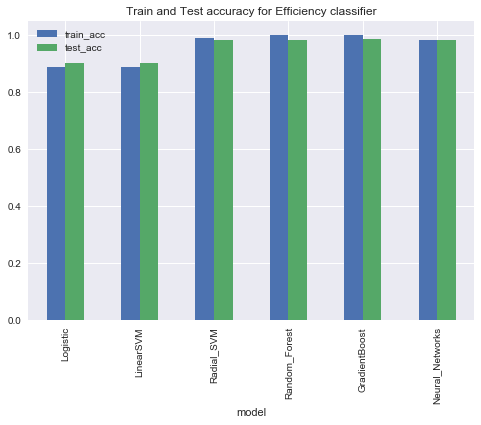

In [38]:
cols = ['model','train_acc','test_acc']
model_results_classification[cols].set_index('model').plot(kind = 'bar');
plt.title('Train and Test accuracy for Efficiency classifier')
#

Text(0.5,1,'Train and Test accuracy for Efficiency classifier')

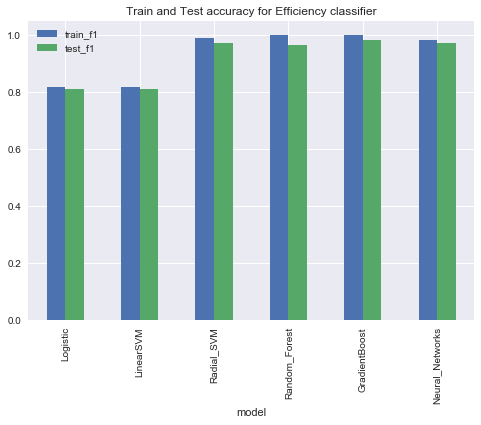

In [39]:
cols = ['model','train_f1','test_f1']
model_results_classification[cols].set_index('model').plot(kind = 'bar');
plt.title('Train and Test accuracy for Efficiency classifier')
#

### Predicting Energy Efficiency Class

- Neural networks along with radial SVM performed the best for the classification problem with highest highest accuracy of 97.2 with no overfitting
- The best parameters for the models are batch size of 10 and 200 epochs